In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import pickle5 as pickle
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import colorcet as cc

# Plotting functions

In [2]:
def plot_state_vector(ax, state_vector_field, cmap, title=None):
    #### FIX: Comment function
    
    # Select map features
    oceans_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')
    lakes_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '50m')
    states_provinces_50m = cartopy.feature.NaturalEarthFeature('cultural','admin_1_states_provinces_lines', '50m')
    ax.add_feature(cartopy.feature.BORDERS, facecolor='none')
    ax.add_feature(oceans_50m, facecolor=[0.9,0.975,1], edgecolor='black')
    ax.add_feature(lakes_50m, facecolor=[0.9,0.975,1], edgecolor='black')
    ax.add_feature(states_provinces_50m, facecolor='none', edgecolor='black')
    
    # Plot
    state_vector_field.plot.imshow(cmap=cmap, add_colorbar=False)
    
    # Remove duplicated axis labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0)
    gl.ylabels_right = False
    gl.xlabels_top = False
    
    # Title
    if title:
        plt.title(title);
        
def plot_field(ax, field, cmap, plot_type='pcolormesh', lon_bounds=None, lat_bounds=None, 
               levels=21, vmin=None, vmax=None, title=None, cbar_label=None, only_ROI=False):
    #### FIX: Comment function
    
    # Select map features
    oceans_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')
    lakes_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '50m')
    states_provinces_50m = cartopy.feature.NaturalEarthFeature('cultural','admin_1_states_provinces_lines', '50m')
    ax.add_feature(cartopy.feature.BORDERS, facecolor='none')
    ax.add_feature(oceans_50m, facecolor=[0.9,0.975,1], edgecolor='black')
    ax.add_feature(lakes_50m, facecolor=[0.9,0.975,1], edgecolor='black')
    ax.add_feature(states_provinces_50m, facecolor='none', edgecolor='black')
    
    # Show only ROI values?
    if only_ROI:
        field = field.where((state_vector_labels <= last_ROI_cluster))  
        #### FIX? Requires pre-defined state_vector_labels and last_ROI_cluster
    
    # Plot
    if plot_type == 'pcolormesh':
        field.plot.pcolormesh(cmap=cmap, levels=levels,
                              vmin=vmin, vmax=vmax, cbar_kwargs={'label':cbar_label,
                                                                 'fraction':0.041, 
                                                                 'pad':0.04})
    elif plot_type == 'imshow':
        field.plot.imshow(cmap=cmap,
                          vmin=vmin, vmax=vmax, cbar_kwargs={'label':cbar_label,
                                                             'fraction':0.041, 
                                                             'pad':0.04})
    else:
        raise ValueError('plot_type must be "pcolormesh" or "imshow"')
    
    # Zoom on ROI?
    if lon_bounds and lat_bounds:
        extent = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
    # Remove duplicated axis labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0)
    gl.ylabels_right = False
    gl.xlabels_top = False
    
    # Title
    if title:
        plt.title(title);

def load_obj(name):
    """ Load something with Pickle. """
    with open( name, 'rb') as f:
        return pickle.load(f)

def regrid_data(df_in):
    #### FIX: how to explain this??
    df = df_in.copy()
    df['lat'] = round(round(df['lat']-0.0455,1)+0.05,2)
    df['lon'] = round(round(df['lon']-0.0455,1)+0.05,2)
    df = df.groupby(['lat','lon']).mean()
    return df

def plot_cols(df, col, ax, cmap='Spectral_r', 
              lon_bounds=None, lat_bounds=None, regrid=True, 
              vmin=None, vmax=None, title=None, cbar_label=None):
    #### FIX: Comment function
    
    # Regrid?
    if regrid:
        df_regrid = regrid_data(df)
        ds = df_regrid.to_xarray()
    else:
        df = df.set_index(['lat','lon'])
        ds = df.to_xarray()
    
    # Map features
    oceans_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')
    lakes_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '50m')
    states_provinces_50m = cartopy.feature.NaturalEarthFeature('cultural', 
                                                               'admin_1_states_provinces_lines', '50m')
    ax.add_feature(cartopy.feature.BORDERS, facecolor='none')
    ax.add_feature(oceans_50m, facecolor=[0.7,0.9,1], edgecolor='black')
    ax.add_feature(lakes_50m, facecolor=[0.7,0.9,1], edgecolor='black')
    ax.add_feature(states_provinces_50m, facecolor='none', edgecolor='black')
   
    # Zoom on ROI?
    if lon_bounds and lat_bounds:
        extent = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0)
    gl.ylabels_right = False
    gl.ylabels_left = True
    gl.xlabels_top = False
    gl.xlabels_bottom = True    
    
    field = ds[col]
    proj = ccrs.PlateCarree()
    if vmin and vmax:
        field.plot.imshow(transform=proj, ax=ax,
                   cmap=cmap, cbar_kwargs={'shrink': 0.75,'label':cbar_label}, 
                   subplot_kws={'projection':proj},
                   vmin=vmin, vmax=vmax)
    else:
        field.plot.imshow(transform=proj, ax=ax,
                   cmap=cmap, cbar_kwargs={'shrink': 0.75,'label':cbar_label}, 
                   subplot_kws={'projection':proj})
        
    if title:
        plt.title(title)

# State vector

In [3]:
# Load state vector file
state_vector_filepath = 'Clusters_permian_kmeans.nc'             #### FIX: Hard-coded, Permian filepath
state_vector = xr.open_dataset(state_vector_filepath)

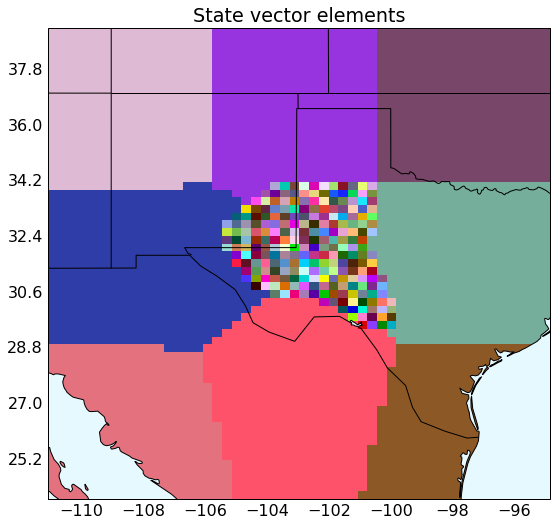

In [4]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

state_vector_labels = state_vector['Clusters']          #### FIX: Remove "clusters" language

plot_state_vector(ax, state_vector_labels, cmap=cc.cm.glasbey, title='State vector elements')

# Inversion results

In [5]:
# Paths to prior emissions, and inversion results, and satellite data
prior_pth = './demonstration_data/edf_prior/HEMCO_diagnostics.201805010000.nc'   #### FIX
scale_pth = './demonstration_data/edf_prior/gridded_posterior.nc'                #### FIX
satdat_dir = './demonstration_data/edf_prior/inversion_output'                   #### FIX
inversion_result_path = './demonstration_data/edf_prior/inversion_result.nc'     #### FIX

In [6]:
# Set latitude/longitude bounds
mean_lon = np.mean(state_vector.lon.values)
mean_lat = np.mean(state_vector.lat.values)
window_radius = 5 # degrees
lon_bounds = [mean_lon-window_radius, mean_lon+window_radius]
lat_bounds = [mean_lat-window_radius, mean_lat+window_radius]

### Prior and Posterior emissions

In [7]:
def sum_total_emissions(emissions, areas, clusters, last_ROI_cluster):
    #### FIX: Remove "clusters" language
    #### FIX: Comment function
    s_per_d = 86400
    d_per_y = 365
    tg_per_kg = 1e-9
    xgrid = range(len(clusters.lon.values))
    ygrid = range(len(clusters.lat.values))    
    permian_mask = (clusters <= last_ROI_cluster)
    emiss = []
    for j in xgrid:
        for i in ygrid:
            if permian_mask.values[i,j] == 1:
                emiss.append(emissions.values[i,j])
    total = np.sum(np.asarray([areas[r] * emiss[r] for r in range(len(areas))]))
    return total * s_per_d * d_per_y * tg_per_kg

In [8]:
# Load prior emissions and optimized scale factors
# Then compute posterior emissions
prior = xr.open_dataset(prior_pth)['EmisCH4_Total'].isel(time=0)
scale = xr.open_dataset(scale_pth)['SF_Nonwetland']                  #### FIX: Remove "Nonwetland" language
posterior = prior * scale

In [9]:
# Compute total emissions
areas = np.load('areas.npy')                                         #### FIX: Need to provide code to create areas.py
last_ROI_cluster = 235                                               #### FIX: Remove "clusters" language

print('Prior     emissions :', sum_total_emissions(prior, areas, state_vector_labels, last_ROI_cluster), 'Tg/y')
print('Posterior emissions :', sum_total_emissions(posterior, areas, state_vector_labels, last_ROI_cluster), 'Tg/y')

Prior     emissions : 2.738888671408107 Tg/y
Posterior emissions : 3.527493489349291 Tg/y


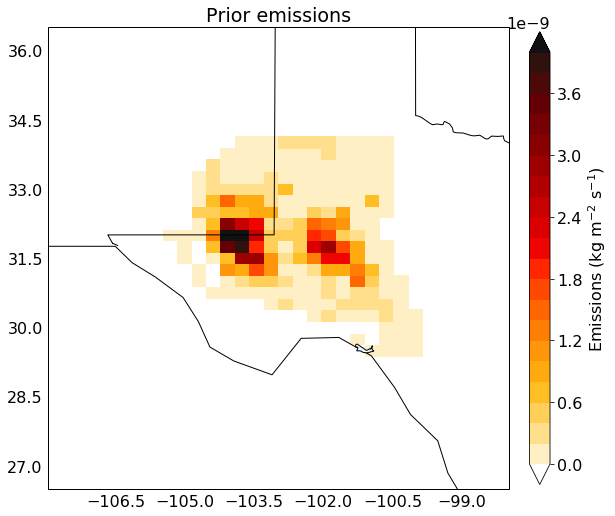

In [10]:
# Plot prior emissions
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, prior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Prior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True)

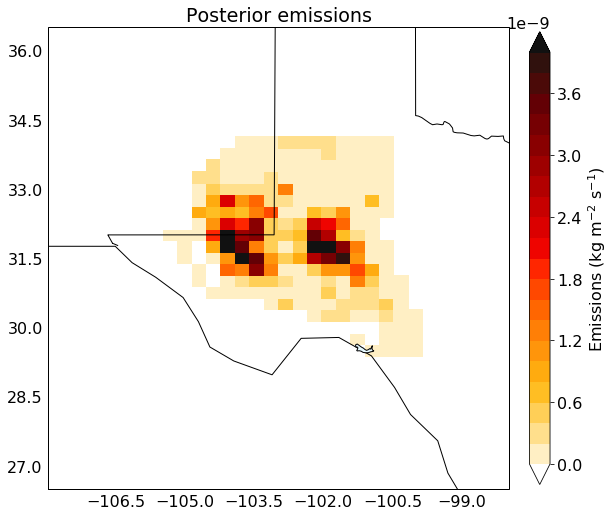

In [11]:
# Plot posterior emissions
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, posterior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Posterior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True)

### Scale factors

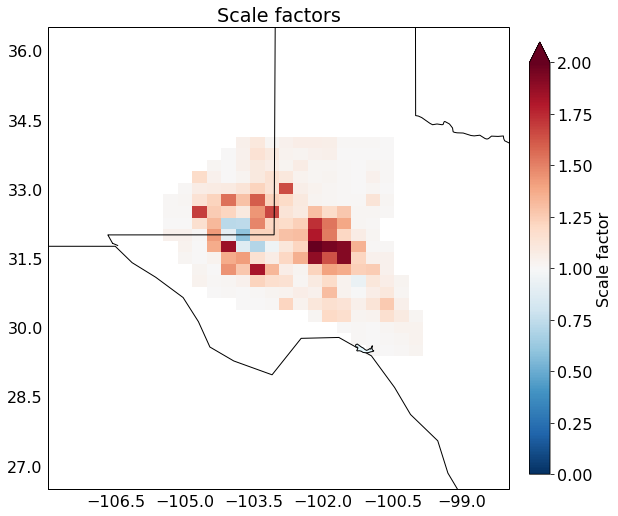

In [12]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, scale, cmap='RdBu_r', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=2, title='Scale factors', cbar_label='Scale factor',
           only_ROI=True)

### Averaging kernel sensitivities

In [13]:
from step3_error_avk import calc_Spost_A                                 #### FIX: now rolled into inversion_results
from make_gridded_averaging_kernel import make_gridded_averaging_kernel  #### FIX: now rolled into inversion_results

In [14]:
S_hat, A = calc_Spost_A(inversion_result_path)
A_diag = np.diag(A).copy()
A_grid = make_gridded_averaging_kernel(A_diag,state_vector_filepath)
A_grid['Averaging_kernel'] = A_grid['Averaging_kernel'].where(state_vector_labels <= last_ROI_cluster)
avkern = A_grid['Averaging_kernel']

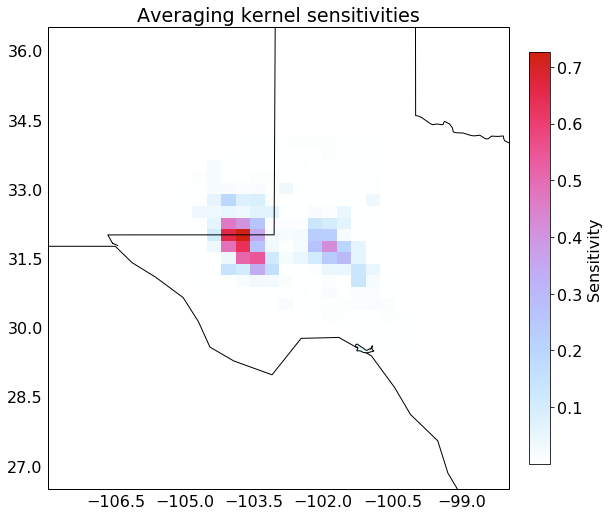

In [15]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, avkern, cmap=cc.cm.CET_L19, plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Averaging kernel sensitivities', cbar_label='Sensitivity', 
           only_ROI=True)

#avkern.plot.imshow(cmap=cc.cm.CET_L19, cbar_kwargs={'label':'Sensitivity',
#                                                 'fraction':0.037, 
#                                                 'pad':0.04})

In [22]:
DOFS = np.sum(A_diag[:last_ROI_cluster])
print('DOFS =', DOFS)

DOFS = 10.847433316047631


# Satellite data

In [16]:
# TROPOMI columns (regridded)
files = np.sort(os.listdir(satdat_dir))
paths = [os.path.join(satdat_dir,r) for r in files]
lat = np.array([])
lon = np.array([])
tropomi = np.array([])
geos = np.array([])

for pth in paths:
    # Load TROPOMI/GEOS-Chem and Jacobian matrix data from the .pkl file
    obj = load_obj(pth)
    # If there aren't any TROPOMI observations on this day, skip
    if obj['obs_GC'].shape[0] == 0:
        continue
    # Otherwise, grab the TROPOMI/GEOS-Chem data
    obs_GC = obj['obs_GC']
    # Only consider data within latitude and longitude bounds
    ind = np.where((obs_GC[:,2]>=lon_bounds[0]) & (obs_GC[:,2]<=lon_bounds[1]) & 
                   (obs_GC[:,3]>=lat_bounds[0]) & (obs_GC[:,3]<=lat_bounds[1]))
    if (len(ind[0]) == 0):          # Skip if no data in bounds
        continue
    obs_GC = obs_GC[ind[0],:]       # TROPOMI and GEOS-Chem data within bounds
    # Record lat, lon, tropomi ch4, and geos ch4
    lat = np.concatenate((lat, obs_GC[:,3]))
    lon = np.concatenate((lon, obs_GC[:,2]))
    tropomi = np.concatenate((tropomi, obs_GC[:,0]))
    geos = np.concatenate((geos, obs_GC[:,1]))
    
df = pd.DataFrame()
df['lat'] = lat
df['lon'] = lon
df['tropomi'] = tropomi
df['geos'] = geos
dat_df = df.copy()
n_obs = len(tropomi)

print('Found',n_obs,'TROPOMI observations')

Found 71932 TROPOMI observations


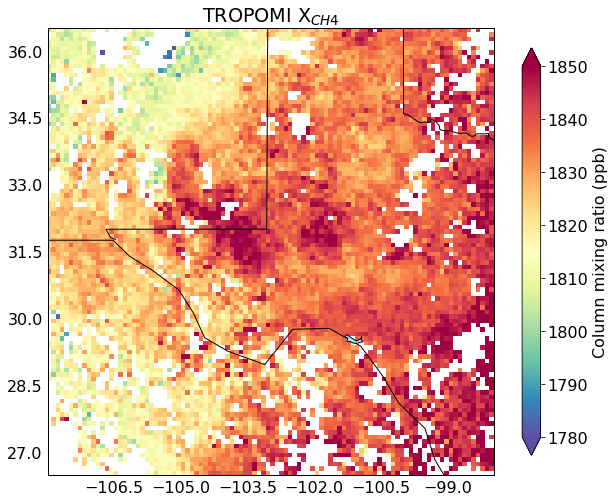

In [17]:
# TROPOMI columns
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_cols(dat_df, 'tropomi', ax, cmap='Spectral_r', lon_bounds=lon_bounds, lat_bounds=lat_bounds, regrid=True, 
          vmin=1780, vmax=1850, title='TROPOMI X$_{CH4}$', cbar_label='Column mixing ratio (ppb)')

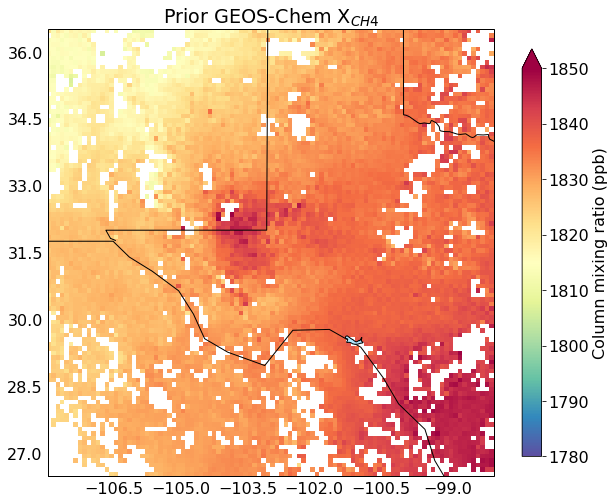

In [18]:
# Prior GEOS-Chem simulated columns
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_cols(dat_df, 'geos', ax, cmap='Spectral_r', lon_bounds=lon_bounds, lat_bounds=lat_bounds, regrid=True, 
          vmin=1780, vmax=1850, title='Prior GEOS-Chem X$_{CH4}$', cbar_label='Column mixing ratio (ppb)')

----